# Mini-Data Set Preparation

After the Kaggle Script "Making a mini-data set" is run (FYI, it takes about 2 minutes to run) to reduce the size of the data to 40,000 instances, run this script to organize data into a single dataframe. 

Run this with the 8 csv files produced by the Kaggle Script in the same directory. 

Note: This is a Python3 script because that is what Kaggle uses. 

Things we've discovered:
* Multiple ad_id per display_id
* Multiple display_id per document_id
* Ad_id can be in multiple display_id and multiple document_id
* Only one ad_id per display_id is clicked

In [1]:
import pandas as pd
import numpy as np
import copy
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [69]:
clicks_train_og = pd.read_csv("../input/clicks_train.csv")
promoted_content_og = pd.read_csv("../input/promoted_content.csv")
doc_cats_og = pd.read_csv("../input/documents_categories.csv")
doc_ents_og = pd.read_csv("../input/documents_entities.csv")
doc_meta_og = pd.read_csv("../input/documents_meta.csv")
doc_topics_og = pd.read_csv("../input/documents_topics.csv")
events_og = pd.read_csv("../input/events.csv")
page_views_og = pd.read_csv("../input/page_views_sample.csv")
clicks_test_og = pd.read_csv("../input/clicks_test.csv")

In [72]:
# FOR TESTING WITH MINI DATASET

doc_ids = set(page_views_og['document_id']) & set(promoted_content_og['document_id'])
# pull in the content that is in both page_views and promoted_content

events = events_og[events_og['document_id'].isin(doc_ids)]
clicks_train = clicks_train_og[clicks_train_og['display_id'].isin(events['display_id'])]
clicks_test = clicks_test_og[clicks_test_og['display_id'].isin(events['display_id'])]

events = events[events['display_id'].isin(clicks_train['display_id'])]

promoted_content = promoted_content_og[promoted_content_og['ad_id'].isin(clicks_train['ad_id'])]
doc_cats = doc_cats_og[doc_cats_og['document_id'].isin(promoted_content['document_id'])]
doc_ents = doc_ents_og[doc_ents_og['document_id'].isin(promoted_content['document_id'])]
doc_meta = doc_meta_og[doc_meta_og['document_id'].isin(promoted_content['document_id'])]
doc_topics = doc_topics_og[doc_topics_og['document_id'].isin(promoted_content['document_id'])]
page_views = page_views_og[page_views_og['document_id'].isin(events['document_id'])]

## Make master data merging all features to clicks_train

### Merge information about the displays to master dataset
Events are only if the user CLICKED. This dataset will bring in information about the display_id's from events

In [150]:
def click_percent(ad_id, default_result, reg):
    '''Returns the posterior probability of ad being clicked.
    If ad has not been encountered before, assume mean click'''
    
    # count number of times ad has been seen
    ad_total = len(dataset[dataset['ad_id'] == ad_id])
    
    # if ad has not been seen, returned the default_results
    if ad_total == 0:
        return default_result
    # otherwise return percentage of times ad has been clicked, adjusted by a regularization term
    else:
        click_sum = np.sum(dataset[dataset['ad_id'] == ad_id].clicked) + 1.0
        return click_sum / (ad_total + reg)
    
def format_data(dataset):

    # Merging information aout the displays to master dataset
    data = dataset.merge(events, on='display_id', how='left')
    # joins information about the display that the user saw
    # each display has a unique user id, doc id, and timestamp
    # events has the information about the display (who the user is, which site (document_id) it was on, when it was seen, from where, etc.)

    # Identifying which documents the ads refer to (aka destination documents)

    data = data.merge(promoted_content, on='ad_id', how='left')

    # Gather/bin data about the documents the ads refer to

    sparsetop = doc_topics.pivot(index='document_id', 
                                 columns='topic_id', 
                                 values='confidence_level')
    sparsetop.columns = ['top_' + str(col) for col in sparsetop.columns]

    sparsecat = doc_cats.pivot(index='document_id', 
                               columns='category_id', 
                               values='confidence_level')
    sparsecat.columns = ['cat_' + str(col) for col in sparsecat.columns]

    sparse = sparsetop.join(sparsecat, how='outer')
    sparse.fillna(0, inplace=True)

    sparse.reset_index(level=0, inplace=True)

    data = data.merge(sparse, 
                      left_on='document_id_y', 
                      right_on='document_id', 
                      how='left')
    
    # Adding meta data about the advertiser and campaign successes
    if 'clicked' in clicks_train.columns:
        advr_success = dict(zip(data.advertiser_id.unique(), 
                                [sum(data[data['advertiser_id']==x]['clicked'])/len(data[data['advertiser_id']==x]) for x in data['advertiser_id'].unique()]))
        camp_success = dict(zip(data.campaign_id.unique(), 
                                [sum(data[data['campaign_id']==x]['clicked'])/len(data[data['campaign_id']==x]) for x in data['campaign_id'].unique()]))

        data['campaign_perc'] = data['campaign_id'].map(camp_success)
        data['advertiser_perc'] = data['advertiser_id'].map(advr_success)

        doc_view_freq = dict(zip(page_views.document_id.unique(), [len(page_views[page_views.document_id==x]) for x in page_views.document_id.unique()]))
        data['docx_view_freq'] = data['document_id_x'].map(doc_view_freq)

        # Adding meta data about prior click percentage
        mean_click = np.mean(dataset["clicked"])
        click_success = dict(zip(data.ad_id.unique(), [click_percent(x, mean_click, 10.0) for x in dataset["ad_id"].unique()] ))
        data['click_perc'] = data['ad_id'].map(click_success)
    
    return data
    
    
#data = format_data(clicks_train)
data_test = format_data(clicks_test)


KeyError: 'clicked'

In [148]:
data.head()

,display_id,ad_id,clicked,uuid,document_id_x,timestamp,platform,geo_location,document_id_y,campaign_id,...,cat_2002,cat_2003,cat_2004,cat_2005,cat_2006,cat_2100,campaign_perc,advertiser_perc,docx_view_freq,click_perc
0,37,70153,0,d4f62cdcb39ad8,1779285,2687,2,US>WA>819,933716,7516,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,7701,0.052632
1,37,149047,0,d4f62cdcb39ad8,1779285,2687,2,US>WA>819,1169985,16636,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,7701,0.076923
2,37,169564,0,d4f62cdcb39ad8,1779285,2687,2,US>WA>819,1394819,20109,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,7701,0.071429
3,37,234713,1,d4f62cdcb39ad8,1779285,2687,2,US>WA>819,1586431,245,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,7701,0.281250
4,37,235443,0,d4f62cdcb39ad8,1779285,2687,2,US>WA>819,1377696,11654,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,7701,0.043478


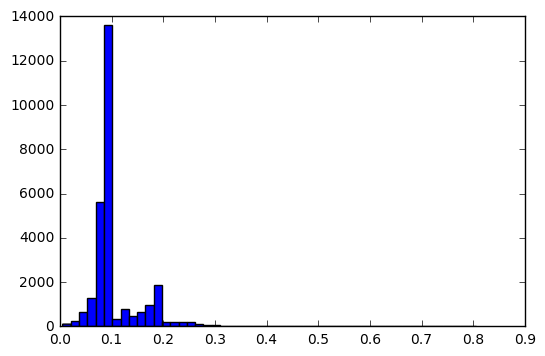

In [144]:
plt.hist(avg_pop, bins=50)
plt.show()

In [81]:
#################3 IGNORE THIS#############3

# Cleanup cells
events['platform'] = map(str, events['platform'])
page_views['platform'] = map(str, page_views['platform'])
page_views['traffic_source'] = map(str, page_views['traffic_source'])

# events['country'], events['state'] = zip(*map(lambda x: str(x).split('>'), list(events['geo_location'])))

# #temp = map(lambda x: str(x).split('>'), list(page_views['geo_location']))
# print temp[:5]
# zip(*temp[:5]) # removes DMA

#events2 = pd.DataFrame(events['geo_location'].str.split(',').tolist(), columns = ['country', 'state', 'dma'])
events['geo_location'].str.split('>', expand= True)
geo = map(lambda x: str(x).split('>'), events['geo_location'])
zip(*geo)
country = [x[0] for x in geo]
#state = [x[1] for x in geo if x[1]]
if None:
    print('a')

Now we are merging information on what documents the ads referred to (from source: promoted_content).  
In every display, there are multiple ads (within one document = document_id_x). Every ad refers to a different document, which is the site the ad is promoting (document_id_y). All the columns after document_id_y are information about that document (to which the ad is referring).

### Merge information about the documents the ads refer to
All the doc files have information about the documents (websites) to which the ads refer to
including confidence levels of which topics the ads referred to, which categories they're apart of, etc.

We wanted to duplicate the idea of the CountVectorizer for the 'bag of words' model we used for spam detection, but since we're not counting words in a text, it's a little bit different. Since we have a 'dictionary' of categories and topics, we use that as our 'vocabulary.' Every document has a confidence level for one or more items in the vocabulary, so we create a sparse matrix with every topic and category as columns, and every document has a confidence level value in the respective columns. If they are not given a confidence level, we put 0 because the document most likely does not have anything to do with that category or topic (given the data provided by Outbrain).

This data on the documents will help us separate ads from one another based on topic/category.  
ie) why did ad A get clicked instead of ad B? We know ad A referred to document 1 whereas ad B referred to document 2, and now we have general information about the documents the ads referred to. We will merge this information in later steps.

creating dictionaries for % of ads clicked for every advertiser and campaign.  
purpose: merge to master dataset as a feature for every ad, how often the advertiser and campaign are successful on average.

Add count of page views to every document that an ad appears in (document_id_x) as a feature, could tell us something about likelihood of ads being clicked

# Make training and test sets

In [ ]:
def make_labels(dataset, train_percent = False):
    # Splitting dataset into data and labels

    labels = data['clicked']
    labels = labels.values.reshape(-1,1)
    del data['clicked']

    print 'Labels length:', len(labels)
    print 'data length:', data.shape

    # Making training and test set splits
    # if not split defined, assume no split desired.
    # split_percent = 1 means test results will be empty
    if not split_percent:
        split_percent = 1
        
    train_data = data[:int(split_percent*len(data))]
    test_data = data[int(split_percentlen*(data)):]

    train_labels = labels[:int(split_percent*len(data))]
    test_labels = labels[int(split_percent*len(data)):]

    print 'training label shape:', train_labels.shape
    print 'training data shape:', train_data.shape
    print 'test label shape:', test_labels.shape
    print 'test data shape:', test_data
    
    return train_data, train_labels, test_data, test_labels

train_data, train_labels, test_data, test_labels = test_train_split(dataset, train_percent = 0.7)

# Following Homework2

In [ ]:
# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [71]:
def lr_prediction(test_data, test_labels, train_data, train_labels):
    '''Returns the array of display_id, ad_id and probability it will be clicked'''
    lr = LogisticRegression()
    lr.fit(train_data[train_data.columns[11:]].fillna(0), train_labels)
    lr_click_prob = lr.predict_proba(test_data[test_data.columns[11:]].fillna(0))[:,1]
    lr_score = lr.score(test_data[test_data.columns[11:]].fillna(0), test_labels)
    return pd.DataFrame({'display_id': test_data['display_id'],
                         'ad_id': test_data['ad_id'],
                         'prediction': lr_click_prob
                        })
lr_output = lr_prediction(test_data, test_labels, train_data, train_labels)

C:\Users\lisam\Anaconda2\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,ad_id,display_id,prediction
197543,12392612,12392612,0.154566
197544,12392612,12392612,0.146541
197545,12392612,12392612,0.151116
197546,12392612,12392612,0.178808
197547,12392620,12392620,0.220336
197548,12392620,12392620,0.203909
197549,12392620,12392620,0.238116
197550,12392620,12392620,0.226653
197551,12392620,12392620,0.200199
197552,12392620,12392620,0.176542


In [ ]:
# Format the data the way the submission requires
output=test.groupby(['display_id'])['ad_id'].apply(lambda x:' '.join(map(str,x))).reset_index()

# That's it for the simple solution (prior expectation)!
output.to_csv('simplesolution3.cvs',index=False)